# Generative text model

We add a text node to the Bayesian network, conditioned on all diagnoses and symptoms. These conditional text distributions are parameterized by 32 Gaussians, one for each unique combination of diagnosis and symptom values. The rest of the nodes in the Bayesian network are parameterized by regular conditional probability tables which can be learned from the data using maximum likelihood estimation. 

![title](figures\models_gen.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
with open("data/train_4000_final.p", "rb") as file: 
    train_df = pickle.load(file)

In [3]:
import pickle
with open("data/test_1000_final.p", "rb") as file: 
    test_df = pickle.load(file)

In [4]:
class_map = {"season": {"warm": 0, "cold": 1}, 
            "pneu": {"no": 0, "yes": 1}, "inf": {"no": 0, "yes": 1}, 
            "dysp": {"no": 0, "yes": 1}, "cough": {"no": 0, "yes": 1}, "nasal": {"no": 0, "yes": 1}}

In [5]:
from utils.data import TabDataset
import torch

emb_type = "BioLORD emb"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # put train and test data on the device
train_set = TabDataset(train_df, class_map, emb_type, device)
test_set = TabDataset(test_df, class_map, emb_type, device)

c:\Users\Paloma\anaconda3\envs\bn-text\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Paloma\Work\bn-text\utils\data.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  preprocessed_data["text"] = torch.tensor(self.dataframe[self.emb_type].tolist(), dtype=torch.float, device=self.device)


In utils.models, you can find the class GenerativeModel. Fitting the distributions in this model consists of two steps.
1. learn all conditional probability tables (CPTs), parameterizing the regular portion of the BN: P(season), P(pneu|season), P(inf|season), P(dysp|pneu), P(cough|pneu,inf), P(nasal|inf)
2. fit conditional text distributions as Gaussians to parameterize P(text|pneu,inf,dysp,cough,nasal)

The code below can be used to do the first step. 

In [14]:
from torch.utils.data import DataLoader
from utils.models import GenerativeModel, GenerativeModelAbl
from torch.optim import Adam

def train_model_generative_CPTs(train, test, node_names, device, model_type="gen", bs_train=100, epochs=100, seed=2023, lr=0.05):
    """
    training loop for fitting CPT portion of generative model
    
    train: set of training samples
    test: set of test samples
    node_names: list of names of regular non-text nodes in the BN
    device: device to load the model to (GPU/CPU)
    model_type: type of model ("gen" or "gen_abl")
    
    bs_train: batch size to use for training
    epochs: number of epochs to train for
    seed: seed to use for initialization
    lr: learning rate 

    returns
        train_loss: list of train losses across epochs
        test_loss: list of test losses across epochs
        train_loss_individual: dict of individual train losses across epochs (i.e. logP for each separate conditional distribution)
        test_loss_individual: dict of individual test losses across epochs (i.e. logP for each separate conditional distribution)
        model: trained BN
    """
    
    torch.manual_seed(seed)
    
    train_loader = DataLoader(train, batch_size=bs_train, shuffle=True)
    test_loader = DataLoader(test, batch_size=len(test), shuffle=False)

    # put model on the device
    if model_type == "gen":
        model = GenerativeModel(seed, device)
        model.to(device)
    elif model_type == "gen_abl":
        model = GenerativeModelAbl(seed, device)
        model.to(device)

    adam = Adam(params=model.parameters(), lr=lr)

    train_loss_individual = {key:[] for key in node_names}
    test_loss_individual = {key:[] for key in node_names}
    train_loss = []
    test_loss = []

    for epoch in range(epochs):

        epoch_loss_individual = {key:0 for key in node_names}
        epoch_loss = 0

        for i, x in enumerate(train_loader): 

            model.train()
            adam.zero_grad()

            LL_fully_obs, LL_part_obs, LL_fully_obs_per_var = model(x) # log likelihood of batch under current parametrization of the model
            batch_loss = -(LL_part_obs.sum()+LL_fully_obs.sum()) # batch loss is sum of all individual losses 
            batch_loss.backward()

            LL_individual = {key: loss.sum() for key, loss in LL_fully_obs_per_var.items()} # sum individual losses per var
            epoch_loss_individual = {key: loss + -LL_individual[key].item() for key, loss in epoch_loss_individual.items()} # store total losses for individual variables per epoch
            epoch_loss += batch_loss.item()
            
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            adam.step()
        
        train_loss_individual = {key: loss_list + [epoch_loss_individual[key]] for key, loss_list in train_loss_individual.items()}
        train_loss.append(epoch_loss/len(train))
            
        with torch.no_grad():
            model.eval()
            for x_test in test_loader: 
                LL_fully_obs, LL_part_obs, LL_fully_obs_per_var = model(x_test)
                LL_individual = {key: loss.sum() for key, loss in LL_fully_obs_per_var.items()} # sum individual losses per var
                test_loss_individual = {key: loss_list + [-LL_individual[key].item()] for key, loss_list in test_loss_individual.items()}
                test_loss.append(-(LL_fully_obs.sum()+LL_part_obs.sum()).item()/len(test))

    for key in train_loss_individual: 
        train_loss_individual[key] = [e/train.len_sympt_obs() for e in train_loss_individual[key]] # only count the times when this loss was counted = number of records where symptoms are observed
        test_loss_individual[key] = [e/test.len_sympt_obs() for e in test_loss_individual[key]]
    
    return train_loss, test_loss, train_loss_individual, test_loss_individual, model

The hyperparameters bs_train, epochs and lr were optimized using a separate train/val split. 

In [ ]:
from sklearn.model_selection import train_test_split
seed = 2024
subtrain_df, val_df = train_test_split(train_df, train_size=0.8, random_state=seed) # use val_df in code below to optimize hyperparameters

Using this train/val split, we landed on the configuration below. 

In [10]:
bs_train = 256
epochs = 15
lr = 0.05
seed = 2024
node_names = ["season", "pneu", "inf", "dysp", "cough", "nasal"]

train_loss, test_loss, train_loss_individual, test_loss_individual, model = train_model_generative_CPTs(train_set, test_set, node_names, device, bs_train=bs_train, epochs=epochs, seed=seed, lr=lr)

The plot below shows that all invidiual CPT losses have converged. 

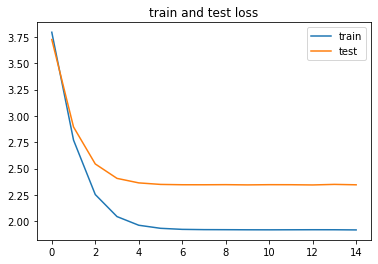

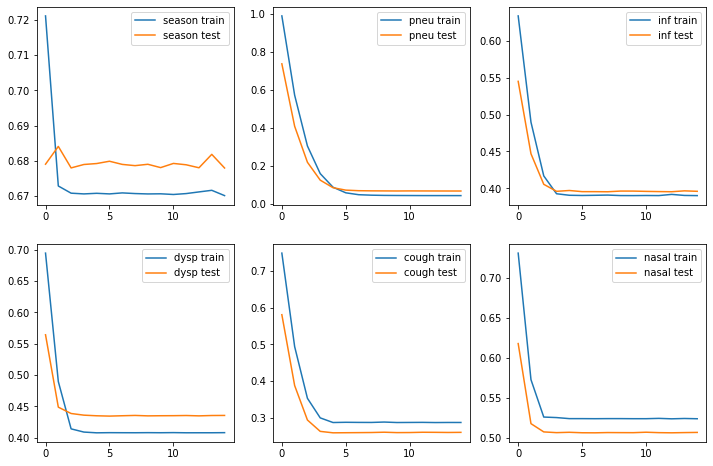

In [11]:
from utils.evaluation import plot_loss
plot_loss(train_loss_individual, test_loss_individual, epochs, train_loss, test_loss)

Now we execute step 2, meaning we parameterize the conditional text distribution P(text|pneu,inf,dysp,cough,nasal) for every possible configuration of the set {pneu,inf,dysp,cough,nasal}. We do this based on the subset of training samples where text is actually observed, since there is no need to model empty text embeddings. Hyperparameter alpha was also optimized based on a train-validation split. 

In [12]:
train_obs = train_df.dropna(axis=0, how="any") # samples where symptoms are not observed cannot contribute to any conditional text distribution, which is conditioned on the value of the symptoms
train_text = train_obs[train_obs["text"] != ""] # only select fully observed samples where text is not empty 

In [16]:
alpha = 0.85
n_emb = 768
model.add_gaussians(train_text, alpha, n_emb)

c:\Users\Paloma\Work\bn-text\utils\models.py:119: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Correlation.cpp:117.)
  else:


Finally, we can use the fitted model to predict the following probabilities: 
- P(Diag=yes|background,symptoms,text)
- P(Diag=yes|background,symptoms) 
- P(Diag=yes|background,text)

We use an exact Bayesian inference procedure for this, which is implemented in infer_query and used by the predict_diagnoses function (see utils.evaluation). 

We also calculate the KL divergence between the learned CPTs and the ground-truth CPTs. 

The code below fits the generative model for 5 seeds and calculates these outcomes for every seed. 

In [11]:
from utils.evaluation import CPD_params, predict_diagnoses, performance_metrics

class_map = {"season": {"warm": 0, "cold": 1}, 
            "pneu": {"no": 0, "yes": 1}, "inf": {"no": 0, "yes": 1}, 
            "dysp": {"no": 0, "yes": 1}, "cough": {"no": 0, "yes": 1}, "nasal": {"no": 0, "yes": 1}}
    
alpha = 0.85
bs_train = 256
epochs = 15
lr = 0.05
n_emb = 768
seed = 2024
node_names = ["season", "pneu", "inf", "dysp", "cough", "nasal"]
emb_type = "BioLORD emb"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seeds = [422, 957, 267, 956, 781]

results = {}

for seed in seeds:

    results[seed] = {}

    ## TRAINING ##

    train_loss, test_loss, train_loss_individual, test_loss_individual, model = train_model_generative_CPTs(train_set, test_set, node_names, device, bs_train=bs_train, epochs=epochs, seed=seed, lr=lr)
    train_obs = train_df.dropna(axis=0, how="any") # samples where symptoms are not observed cannot contribute to any conditional text distribution, which is conditioned on the value of the symptoms
    train_text = train_obs[train_obs["text"] != ""] # only select fully observed samples where text is not empty 
    model.add_gaussians(train_text, alpha, n_emb)

    ## EVALUATION ##

    # KL divergence
    _, _, KL = CPD_params(model, "gen")
    results[seed][f"KL"] = KL

    # P(pneu=yes|background,symptoms,text)
    pred_df = predict_diagnoses(model, test_set, 1, model_type="gen")
    _, ap = performance_metrics(pred_df, "pneu", model_type="gen", plot=False) 
    results[seed][f"P(pneu|season,symptoms,text) test PR"] = ap
    _, ap = performance_metrics(pred_df, "inf", model_type="gen", plot=False) 
    results[seed][f"P(inf|season,symptoms,text) test PR"] = ap

    # P(pneu=yes|background,symptoms)
    pred_df = predict_diagnoses(model, test_set, 1, model_type="gen", excl_text=True)
    _, ap = performance_metrics(pred_df, "pneu", model_type="gen", plot=False) 
    results[seed][f"P(pneu|season,symptoms) test PR"] = ap
    _, ap = performance_metrics(pred_df, "inf", model_type="gen", plot=False) 
    results[seed][f"P(inf|season,symptoms) test PR"] = ap

    # P(pneu=yes|background,text)
    pred_df = predict_diagnoses(model, test_set, 1, model_type="gen", excl_sympt=True)
    _, ap = performance_metrics(pred_df, "pneu", model_type="gen", plot=False) 
    results[seed][f"P(pneu|season,text) test PR"] = ap
    _, ap = performance_metrics(pred_df, "inf", model_type="gen", plot=False) 
    results[seed][f"P(inf|season,text) test PR"] = ap

cpu


c:\Users\Paloma\Work\bn-text\utils\models.py:119: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Correlation.cpp:117.)
  cov = torch.cov(embs.t()) # from docs of cov function: rows are variables, columns are observations -> need to transpose emb
c:\Users\Paloma\Work\bn-text\utils\models.py:119: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Correlation.cpp:117.)
  cov = torch.cov(embs.t()) # from docs of cov function: rows are variables, columns are observations -> need to transpose emb
c:\Users\Paloma\Work\bn-text\utils\models.py:119: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Correlation.cpp:117.)
  cov = torch.cov(embs.t()) # from docs of cov function: rows are variables, columns are observations -> need to transpose emb
c:\Users\Paloma\Work\bn-t

In [12]:
results

{422: {'KL': 0.00394699651936337,
  'P(pneu|season,symptoms,text) test PR': 0.587030869333911,
  'P(inf|season,symptoms,text) test PR': 0.7972179604573827,
  'P(pneu|season,symptoms) test PR': 0.09014052651578963,
  'P(inf|season,symptoms) test PR': 0.8888777490041548,
  'P(pneu|season,text) test PR': 0.44336844001611814,
  'P(inf|season,text) test PR': 0.7627988382682274},
 957: {'KL': 0.00406827583550339,
  'P(pneu|season,symptoms,text) test PR': 0.587030869333911,
  'P(inf|season,symptoms,text) test PR': 0.7960016164194188,
  'P(pneu|season,symptoms) test PR': 0.08864676229611904,
  'P(inf|season,symptoms) test PR': 0.8888777490041548,
  'P(pneu|season,text) test PR': 0.44336511872247425,
  'P(inf|season,text) test PR': 0.7603235442632299},
 267: {'KL': 0.0033924094495796273,
  'P(pneu|season,symptoms,text) test PR': 0.5870232961654527,
  'P(inf|season,symptoms,text) test PR': 0.7974501031464627,
  'P(pneu|season,symptoms) test PR': 0.08864676229611904,
  'P(inf|season,symptoms) tes

## Ablation of generative text model

We remove the arrows from pneu -> text and inf -> text, meaning we only fit 8 Gaussians instead of 32. The adapted model class is called "GenerativeModelAbl". 

Again, we run over 5 different initialization seeds.

In [15]:
from utils.evaluation import CPD_params, predict_diagnoses, performance_metrics

class_map = {"season": {"warm": 0, "cold": 1}, 
            "pneu": {"no": 0, "yes": 1}, "inf": {"no": 0, "yes": 1}, 
            "dysp": {"no": 0, "yes": 1}, "cough": {"no": 0, "yes": 1}, "nasal": {"no": 0, "yes": 1}}
    
alpha = 0.85
bs_train = 256
epochs = 15
lr = 0.05
n_emb = 768
seed = 2024
node_names = ["season", "pneu", "inf", "dysp", "cough", "nasal"]
emb_type = "BioLORD emb"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

test_set = TabDataset(test_df, class_map, emb_type, device)

train_sizes = [4000]
seeds = [422, 957, 267, 956, 781]

results = {}

for seed in seeds:

    results[seed] = {}

    ## TRAINING ##

    train_loss, test_loss, train_loss_individual, test_loss_individual, model = train_model_generative_CPTs(train_set, test_set, node_names, device, bs_train=bs_train, epochs=epochs, seed=seed, lr=lr, model_type="gen_abl")
    train_obs = train_df.dropna(axis=0, how="any") # samples where symptoms are not observed cannot contribute to any conditional text distribution, which is conditioned on the value of the symptoms
    train_text = train_obs[train_obs["text"] != ""] # only select fully observed samples where text is not empty 
    model.add_gaussians(train_text, alpha, n_emb)

    ## EVALUATION ##

    # KL divergence
    _, _, KL = CPD_params(model, "gen")
    results[seed][f"KL"] = KL

    # P(pneu=yes|background,symptoms,text)
    pred_df = predict_diagnoses(model, test_set, 1, model_type="gen")
    _, ap = performance_metrics(pred_df, "pneu", model_type="gen", plot=False) 
    results[seed][f"P(pneu|season,symptoms,text) test PR"] = ap
    pred_df = predict_diagnoses(model, test_set, 1, model_type="gen")
    _, ap = performance_metrics(pred_df, "inf", model_type="gen", plot=False) 
    results[seed][f"P(inf|season,symptoms,text) test PR"] = ap

    # P(pneu=yes|background,symptoms)
    pred_df = predict_diagnoses(model, test_set, 1, model_type="gen", excl_text=True)
    _, ap = performance_metrics(pred_df, "pneu", model_type="gen", plot=False) 
    results[seed][f"P(pneu|season,symptoms) test PR"] = ap
    pred_df = predict_diagnoses(model, test_set, 1, model_type="gen", excl_text=True)
    _, ap = performance_metrics(pred_df, "inf", model_type="gen", plot=False) 
    results[seed][f"P(inf|season,symptoms) test PR"] = ap

    # P(pneu=yes|background,text)
    pred_df = predict_diagnoses(model, test_set, 1, model_type="gen", excl_sympt=True)
    _, ap = performance_metrics(pred_df, "pneu", model_type="gen", plot=False) 
    results[seed][f"P(pneu|season,text) test PR"] = ap
    pred_df = predict_diagnoses(model, test_set, 1, model_type="gen", excl_sympt=True)
    _, ap = performance_metrics(pred_df, "inf", model_type="gen", plot=False) 
    results[seed][f"P(inf|season,text) test PR"] = ap

cpu


In [16]:
results

{422: {'KL': 0.00394699651936337,
  'P(pneu|season,symptoms,text) test PR': 0.09014052651578963,
  'P(inf|season,symptoms,text) test PR': 0.8888777490041548,
  'P(pneu|season,symptoms) test PR': 0.09014052651578963,
  'P(inf|season,symptoms) test PR': 0.8888777490041548,
  'P(pneu|season,text) test PR': 0.09420362698454747,
  'P(inf|season,text) test PR': 0.8912535567330802},
 957: {'KL': 0.00406827583550339,
  'P(pneu|season,symptoms,text) test PR': 0.08864676229611904,
  'P(inf|season,symptoms,text) test PR': 0.8888777490041548,
  'P(pneu|season,symptoms) test PR': 0.08864676229611904,
  'P(inf|season,symptoms) test PR': 0.8888777490041548,
  'P(pneu|season,text) test PR': 0.09200772797174481,
  'P(inf|season,text) test PR': 0.8913817961646368},
 267: {'KL': 0.0033924094495796273,
  'P(pneu|season,symptoms,text) test PR': 0.08864676229611904,
  'P(inf|season,symptoms,text) test PR': 0.8888777490041548,
  'P(pneu|season,symptoms) test PR': 0.08864676229611904,
  'P(inf|season,symptoms